In [4]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

acc,▁▇▇▆██▇█
loss,█▂▅▁▂▂▁▁
acc,0.84559
loss,0.13494


In [ ]:
from itertools import combinations_with_replacement

# Read input
input_string, r = input().split()
r = int(r)

# Generate combinations
combinations = combinations_with_replacement(sorted(input_string), r)

# Print each combination
for combo in combinations:
    print(''.join(combo))

In [2]:
from dataclasses import dataclass

@dataclass
class Human:
    x: str = 'hello'
    y: int = 21

Human()

Human(x='hello', y=21)

<h1> PyTorch Lightning Basics </h1>

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.optim import Adam, lr_scheduler

# Path to save datasets
DATA_DIR = r'/home/zkllmt/Documents/AI Section/Repositories/Computer-Vision/'


# Dataset class
class Data(Dataset):
    def __init__(self, f, transform=None):
        self.f = f
        self.transform = transform
    
    def __len__(self): 
        return len(self.f)

    def __getitem__(self, ix):
        img, lbl = self.f[ix]
        if self.transform:
            img = self.transform(img)
        return img, lbl

    def collate_fn(self, batch):
        imgs, lbls = zip(*batch)  # Unzip the batch
        imgs = torch.stack(imgs)  # Stack images into a tensor
        lbls = torch.tensor(lbls) # Convert labels to a tensor
        return imgs, lbls


# LightningDataModule
class FashionMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = T.Compose([
            T.Resize(28),
            T.RandomCrop(28),
            T.ToTensor()
        ])
        self.data_dir = DATA_DIR
    
    def prepare_data(self):
        # Download the datasets
        torchvision.datasets.FashionMNIST(self.data_dir, train=True, download=True)
        torchvision.datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Load datasets
        train = torchvision.datasets.FashionMNIST(self.data_dir, train=True)
        test = torchvision.datasets.FashionMNIST(self.data_dir, train=False)
        self.train_ds = Data(train, transform=self.transform)
        self.test_ds = Data(test, transform=self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self.train_ds.collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, collate_fn=self.test_ds.collate_fn)

# PyTorch Lightning basic cycle
#1. prepate data
#2. setup
#3. train_dataloader
#4. val_dataloader
#5. forward propagation
#6. training step
#7. validation step
#8. configure optimizer



# LightningModule
class FashionMNISTModel(LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        imgs, lbls = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, torch.tensor(lbls).long())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, lbls = batch
        logits = self(imgs)
        val_loss = self.loss_fn(logits, torch.tensor(lbls).long())
        self.log('val_loss', val_loss)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        return [optimizer], [scheduler]


# Main training script
if __name__ == "__main__":
    # Initialize DataModule and Model
    data_module = FashionMNISTDataModule(batch_size=32)
    model = FashionMNISTModel()

    # Trainer with progress bar callback
    trainer = pl.Trainer(
        max_epochs=5,
        callbacks=[TQDMProgressBar()],
        log_every_n_steps=10
    )
    trainer.fit(model, data_module)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 101 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/tmp/ipykernel_106654/324883688.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = self.loss_fn(logits, torch.tensor(lbls).long())
/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 1/1875 [00:00<03:18,  9.46it/s, v_num=22]

/tmp/ipykernel_106654/324883688.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(logits, torch.tensor(lbls).long())


Epoch 4: 100%|██████████| 1875/1875 [00:45<00:00, 40.86it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1875/1875 [00:45<00:00, 40.84it/s, v_num=22]


In [2]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.1226), 'val_loss': tensor(0.3415)}


In [1]:
import torch
import torchvision
import torch.nn as nn
from torch_snippets import *
from torch.optim import Adam, lr_scheduler
from torchsummary import summary
from torchvision.transforms import transforms as T
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning.callbacks import TQDMProgressBar
import cv2

f = r'/home/zkllmt/Documents/AI Section/Repositories/Computer-Vision/'

# Custom Dataset class
class Data(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self): 
        return len(self.data)

    def __getitem__(self, ix):
        img, lbl = self.data[ix]
        if self.transform:
            img = self.transform(img)
        return img, lbl

    def collate_fn(self, batch):
        imgs, lbls = zip(*batch)
        imgs = torch.stack([T.ToTensor()(img) for img in imgs])  # Convert each PIL.Image to a tensor
        lbls = torch.tensor(lbls, dtype=torch.long)  # Ensure labels are long tensors
        return imgs, lbls

class ModelDataModule(LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.f = f
        self.transform = T.Compose([T.Resize(28)])

    def prepare_data(self):
        # Download the datasets
        torchvision.datasets.FashionMNIST(self.f, train=True, download=True)
        torchvision.datasets.FashionMNIST(self.f, train=False, download=True)

    def setup(self, stage=None):
        # Load the full training set
        full_train = torchvision.datasets.FashionMNIST(self.f, train=True, transform=self.transform)
        
        # Split training data into train and validation
        train_size = int(0.8 * len(full_train))
        val_size = len(full_train) - train_size
        self.train_ds, self.val_ds = torch.utils.data.random_split(
            full_train, [train_size, val_size]
        )
        
        # Test dataset
        test = torchvision.datasets.FashionMNIST(self.f, train=False, transform=self.transform)
        self.test_ds = Data(test, transform=self.transform)
        
        # Wrap train and val in our custom Dataset
        self.train_ds = Data(self.train_ds, transform=self.transform)
        self.val_ds = Data(self.val_ds, transform=self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, 
                        shuffle=True, collate_fn=self.train_ds.collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size,
                        shuffle=False, collate_fn=self.val_ds.collate_fn)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size,
                        shuffle=False, collate_fn=self.test_ds.collate_fn)
# Define the Model class


class Model(LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-3, threshold=1e-4)
        return [optimizer], [{'scheduler': scheduler, 'monitor': 'val_loss'}]
    
    def training_step(self, batch, batch_idx):
        ims, lbls = batch
        logits = self(ims)
        loss = self.loss_fn(logits, lbls)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        ims, lbls = batch
        logits = self(ims)
        val_loss = self.loss_fn(logits, lbls)
        self.log('val_loss', val_loss, prog_bar=True)
        return {'val_loss': val_loss}

    def test_step(self, batch, batch_idx):
        ims, lbls = batch
        logits = self(ims)
        test_loss = self.loss_fn(logits, lbls)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == lbls).float().mean()
        
        # Log metrics
        self.log('test_loss', test_loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return {'test_loss': test_loss, 'test_acc': acc}

    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val_loss']
        self.log('val_loss', avg_val_loss, prog_bar=True)


# Create the model and data module instances
model = Model(num_classes=10)
data_module = ModelDataModule(batch_size=32)

# Set up the trainer
trainer = pl.Trainer(
    max_epochs=5, 
    devices=1,  # Specify devices=1 for CPU
    accelerator="cpu",  # Explicitly set to CPU if no GPU is available
    enable_progress_bar=True
)

# Start training
trainer.fit(model, data_module)

# Evaluate on the test set
trainer.test(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 101 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1500/1500 [00:30<00:00, 48.42it/s, v_num=34, train_loss=0.306, val_loss=0.343] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1500/1500 [00:30<00:00, 48.40it/s, v_num=34, train_loss=0.306, val_loss=0.343]


/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:03<00:00, 87.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8654000163078308     │
│         test_loss         │    0.3781231641769409     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3781231641769409, 'test_acc': 0.8654000163078308}]

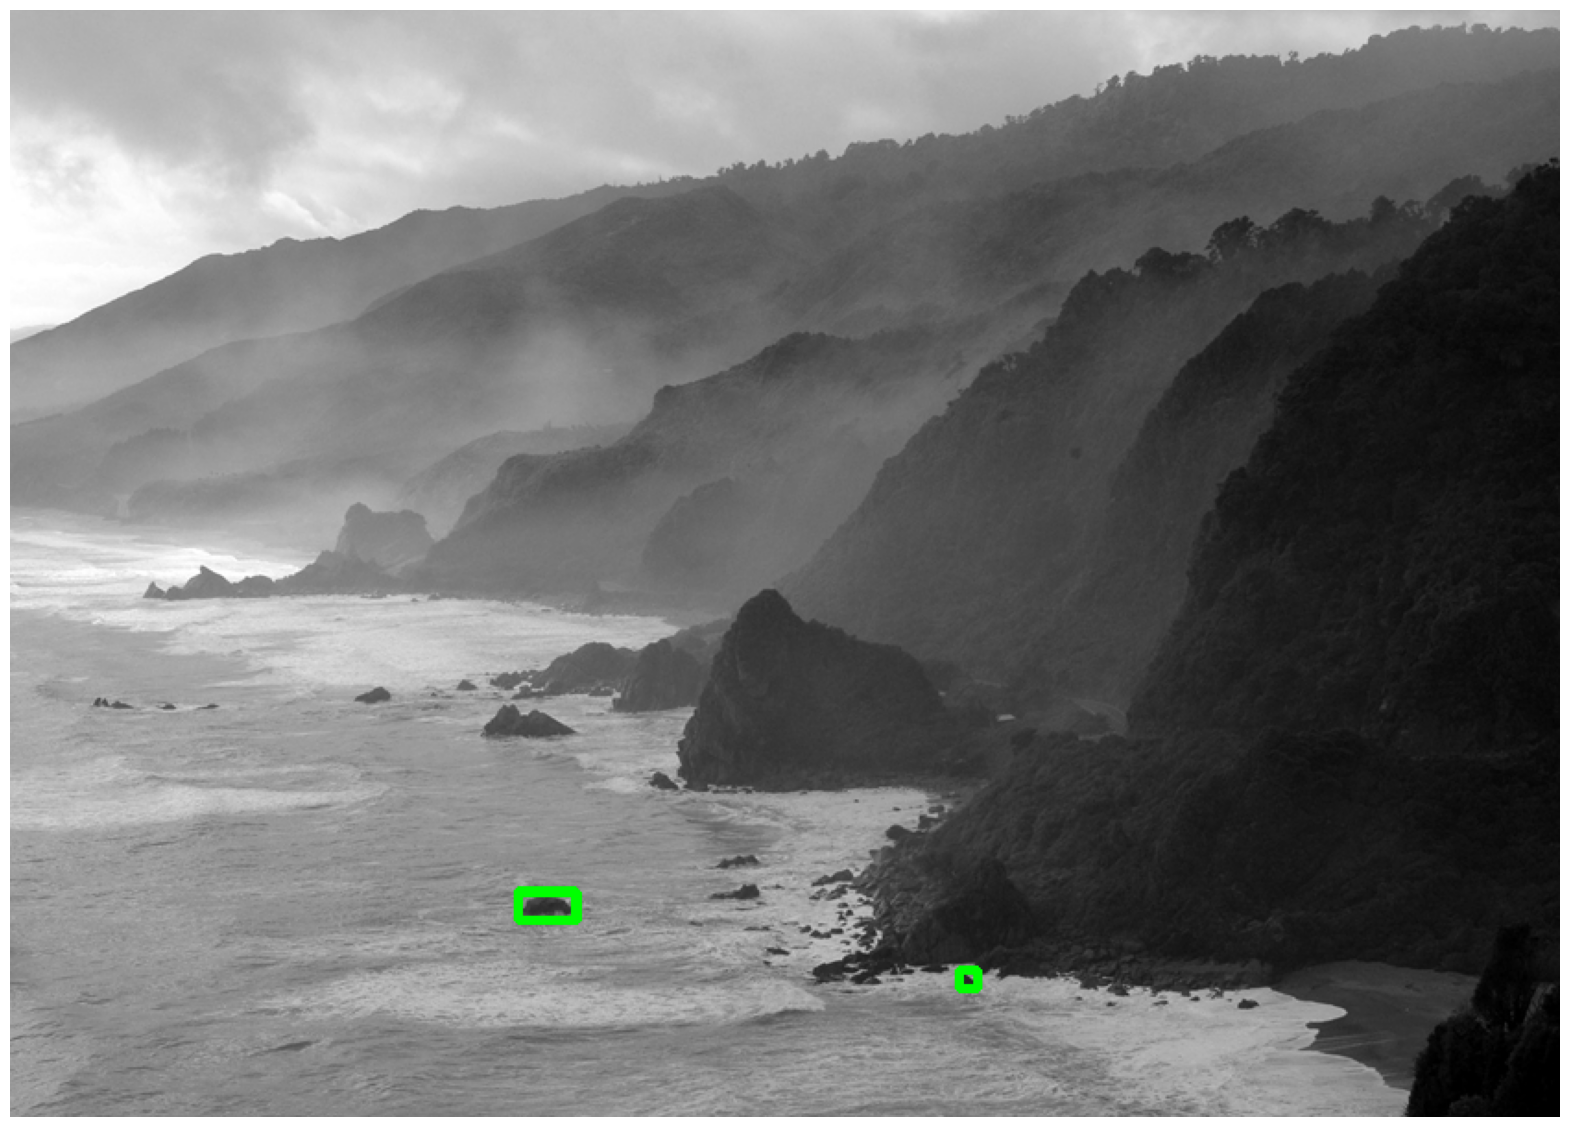

In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
from torch_snippets import *
# Load the model pre-trained on COCO dataset
model = fasterrcnn_resnet50_fpn(weights ='DEFAULT')
model.eval()  # Set the model to evaluation mode

# Load and preprocess the image
image_path = "sample11.png"
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image)  # Convert image to tensor
# Add a batch dimension
with torch.no_grad():
    predictions = model([image_tensor])

# Predictions contain boxes, labels, and scores
for box, label, score in zip(
    predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']
):
    if score > 0.5:  # Filter out low-confidence predictions
        print(f"Box: {box}, Label: {label}, Score: {score}")

boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']
show(image_path, bbs = boxes, )